In [37]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

from WanPy import *
from pythtb import *
from pythTB_wan import *
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/Users/treycole/Codes/WanPy/top_obstruction


In [50]:
# tight-binding parameters
delta = 1
# # checkerboard
# t0 = 0.4
# tprime = 0.5
# Haldane
t = -1
t2 = 0.4

n_super_cell = 2
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])
# model = models.chessboard(t0, tprime, delta).make_supercell([[n_super_cell, 0], [0, n_super_cell]])
model.display()

---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 2
r-space dimension           = 2
number of spin components   = 1
periodic directions         = [0, 1]
number of orbitals          = 8
number of electronic states = 8
lattice vectors:
 #  0  ===>  [     2.0 ,     0.0 ]
 #  1  ===>  [     1.0 ,  1.7321 ]
positions of orbitals:
 #  0  ===>  [  0.1667 ,  0.1667 ]
 #  1  ===>  [  0.3333 ,  0.3333 ]
 #  2  ===>  [  0.1667 ,  0.6667 ]
 #  3  ===>  [  0.3333 ,  0.8333 ]
 #  4  ===>  [  0.6667 ,  0.1667 ]
 #  5  ===>  [  0.8333 ,  0.3333 ]
 #  6  ===>  [  0.6667 ,  0.6667 ]
 #  7  ===>  [  0.8333 ,  0.8333 ]
site energies:
 #  0  ===>      -1.0
 #  1  ===>       1.0
 #  2  ===>      -1.0
 #  3  ===>       1.0
 #  4  ===>      -1.0
 #  5  ===>       1.0
 #  6  ===>      -1.0
 #  7  ===>       1.0
hoppings:
<  0 | H |  1 + [  0 ,  0 ] >     ===>     -1.0 +     0.0 i
<  0 | H |  5 + [ -1 ,  0 ] >     ===>    

In [51]:
low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()

n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern_occ = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)
chern_cond = u_wfs_full.berry_flux([i for i in range(n_occ, n_orb)])/(2*np.pi)

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern_occ: .1f}")
print(f"Chern # conduction: {chern_cond: .1f}")

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied: -1.0
Chern # conduction:  1.0


In [60]:
random = False
low_E = False

if random:
    omit_num = 1
    n_tfs = n_occ - omit_num
    tf_list = ["random", n_tfs]
else:
    omit_sites = 6
    tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site
    # np.random.choice(low_E_sites, n_tfs, replace=False)
    n_tfs = len(tf_list)
if low_E:
    tf_list = list(low_E_sites)
    n_tfs = len(tf_list)

Wan_frac = n_tfs/n_occ
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")

# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75


k-path

In [62]:
path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0]]
label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $')

nk = 101
(k_vec, k_dist, k_node) = model.k_path(path, nk, report=False)

In [63]:
eigvals, eigvecs = model.solve_all(k_vec, eig_vectors=True)
eigvecs = np.transpose(eigvecs, axes=(1,0,2))

In [64]:
WF = Wannier(model, [20, 20])
twfs = WF.get_trial_wfs(tf_list)
state_idx = list(range(n_occ))

In [65]:
def tf_overlap_mat(psi_wfs, tfs, state_idx):
    """
    Returns A_{k, n, j} = <psi_{n,k} | t_{j}> where psi are Bloch states and t are
    the trial wavefunctions.

    Args:
        psi_wfs (np.array): Bloch eigenstates
        tfs (np.array): trial wfs
        state_idx (list): band indices to form overlap matrix with

    Returns:
        A (np.array): overlap matrix
    """
    psi_wfs = np.take(psi_wfs, state_idx, axis=-2)
    A = np.einsum("...ij, kj -> ...ik", psi_wfs.conj(), tfs)
    return A

In [66]:
A = tf_overlap_mat(eigvecs, twfs, state_idx)
V, S, Wh = np.linalg.svd(A, full_matrices=False)

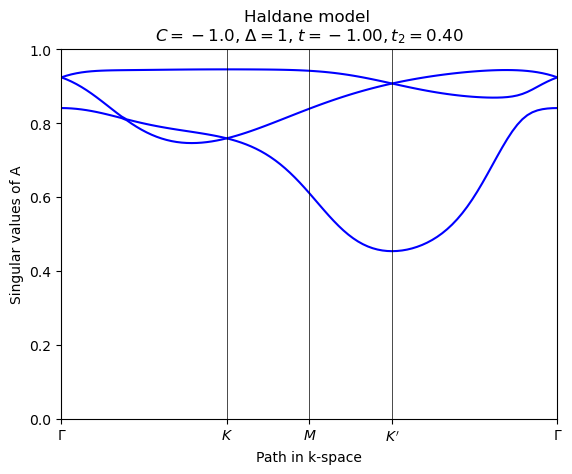

In [67]:
# figure for bandstructure
fig, ax = plt.subplots()

# plot bands
for n in range(S.shape[-1]):
  ax.plot(k_dist, S[:, n], c='b')

# add vertical lines at node positions
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')

ax.set_xlim(k_node[0], k_node[-1])
ax.set_ylim(0,1)
ax.set_xticks(k_node)
ax.set_xticklabels(label)

ax.set_title(
  "Haldane model \n"
  fr"$C = {chern_occ: .1f}$, $\Delta = {delta}$, $t= {t: .2f}, t_2 = {t2: .2f}$"
  )
ax.set_xlabel("Path in k-space")
ax.set_ylabel("Singular values of A")

save_name = f'C={chern_occ:.1f}_Delta={delta}_t={t}_t2={t2}_n_occ={n_occ}_n_tfs={n_tfs}'
plt.savefig(f'images/Haldane_2x2SC_{save_name}.png')